In [1]:
import mygene
import numpy as np
import pandas as pd
import os
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
nean_data_dir = "./neanderthal_introgressed/"
allen_data_dir = "./alleninf/alleninf/data/"
donor_data_dir = "./donor_data/"
MNI_brain = "/usr/share/fsl/5.0/data/standard/MNI152_T1_1mm_brain.nii.gz"

CLOBBER = False
MNI_corr = pd.read_csv(os.path.join(allen_data_dir,"corrected_mni_coordinates.csv"),header=0,index_col=0)
# see NOTES.txt for a description of contents, note that CIs may need to be incorporated but the "per_genene"
# file gives us a place to start
nn_CB_per_gene = pd.read_csv(os.path.join(nean_data_dir,"ase_cerebellum.per_gene.txt"),sep="\t",header=0)
nn_CB_per_snp  = pd.read_csv(os.path.join(nean_data_dir,"ase_cerebellum.per_snp.txt"),sep="\t",header=0)

out_ensembl2gene = "ase_cerebellum_ensembl2gene.csv"

In [3]:
MNI_corr.head()

,corrected_mni_x,corrected_mni_y,corrected_mni_z
well_id,,,
126439333,-13.467693,2.255686,3.432523
126432538,-53.603259,-8.120055,0.868643
126435762,-16.288739,-34.198856,-19.944686
126439285,-17.820212,3.595613,-32.872868
126435744,-23.726456,-25.139000,-16.692841


In [4]:
nn_CB_per_snp.head()

,chrom,pos,geneid,est.mean,sd.sd,ci0.005,ci0.025,ci0.975,ci0.995,REF,ALT,RSID,ANCESTRAL,GLOBAL_AF,EAS_AF,EUR_AF,est.scaled,est.scaled.polarized
0,1,3551792,ENSG00000116213,-0.117100,0.019119,-0.166485,-0.154656,-0.079607,-0.067841,G,A,rs2296034,G,0.078674,0.1915,0.0388,-0.120094,-0.120094
1,1,10220149,ENSG00000130939,0.559621,0.626792,-0.962172,-0.617283,1.848444,2.294328,T,G,rs77148178,T,0.006190,0.0000,0.0219,1.763459,1.763459
2,1,10221136,ENSG00000130939,-1.386307,0.790525,-3.718340,-3.090941,0.013753,0.390911,G,C,rs114631287,G,0.006190,0.0000,0.0219,-3.652746,-3.652746
3,1,10334544,ENSG00000054523,-0.080021,0.400384,-1.120116,-0.869507,0.702521,0.946659,C,T,rs115415660,C,0.006589,0.0000,0.0229,-0.016892,-0.016892
4,1,10363664,ENSG00000054523,-0.040922,0.043353,-0.153018,-0.126138,0.044048,0.070686,G,T,rs41274458,G,0.006589,0.0000,0.0229,0.091934,0.091934


In [5]:
nn_CB_per_gene.head()

,geneid,est.scaled.polarized.mean
0,ENSG00000000457,0.527106
1,ENSG00000002746,-0.887026
2,ENSG00000003249,-0.594831
3,ENSG00000003987,0.451745
4,ENSG00000004799,0.137427


In [6]:
## extract gene names and additional information about the gene from the ensemble ID
genes = nn_CB_per_gene['geneid'] #these are the ensemble gene ids, called "ensembl.gene" in mygene
fields = "alias,summary,symbol,name,taxid,entrezgene,ensembl.gene"
if not os.path.isfile(out_ensembl2gene) or CLOBBER == True:
    mg = mygene.MyGeneInfo()
    df_genes = mg.querymany(list(genes),species="human",
                            fields=fields,
                            as_dataframe=True,
                            email="christopher.steele@mail.mcgill.ca")
    df_genes.to_csv(out_ensembl2gene)
else:
    df_genes = pd.read_csv(out_ensembl2gene)

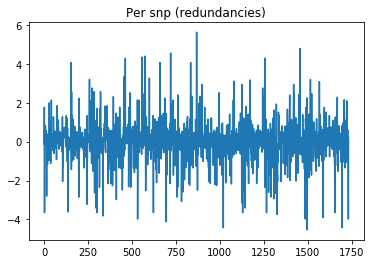

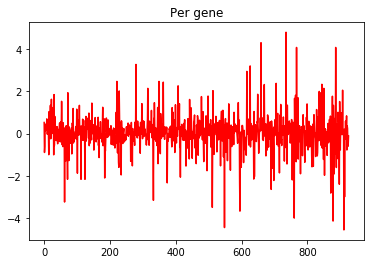

In [7]:
plt.plot(nn_CB_per_snp['est.scaled.polarized'])
plt.title('Per snp (redundancies)')
#plt.bar(np.arange(nn_CB_per_snp.shape[0]),nn_CB_per_snp['est.scaled.polarized'])
plt.figure()
plt.plot(nn_CB_per_gene['est.scaled.polarized.mean'],'r')
plt.title('Per gene')

In [8]:
## merge the df_genes with our neanderthal data
df_gene_nn = pd.merge(df_genes,nn_CB_per_gene,left_on="query",right_on="geneid")


--- THIS ENDS THE CODE THAT EXTRACTS THE NEANDERTHAL GENES AND THEIR RELEVANT GENE_SYMBOLS FROM MYGENE ---

In [314]:
## work with the code that K. Gorgolewski wrote
# reads allen database donor data (whatever is in the dir)
def read_donor_data(data_dir):
    from glob import glob
    donor_ids = [path.split(os.path.sep)[-2] for path in glob(os.path.join(data_dir, "*", "MicroarrayExpression.csv"))]
    print "Data directory contains the following donors: %s" % ", ".join(donor_ids)
    main_df = "empty"
    for donor_id in donor_ids:
        print "Reading data from donor %s"%donor_id
        sample_locations = pd.read_csv(os.path.join(data_dir, donor_id, 'SampleAnnot.csv'))
        df = pd.DataFrame([donor_id] * sample_locations.shape[0], columns=["donor_id"]) #column of donor_id
        df_well_ids = sample_locations[['well_id',"slab_type"]] #keep slab type so that we can filter on it
        df = pd.concat([df,df_well_ids],axis=1,ignore_index=False)
        expression_data = pd.read_csv(os.path.join(data_dir, donor_id, 'MicroarrayExpression.csv'),
                                      header=None, index_col=0)
        expression_data.columns = range(expression_data.shape[1])
        df = pd.concat([df, expression_data.T], axis=1, ignore_index=False)
        if isinstance(main_df, str):
            main_df = df
        else:
            main_df = pd.concat([main_df, df], ignore_index=True)
    return main_df #now formatted by row,col sample_well_id,probe_id

In [315]:
#df_donors = read_donor_data(donor_data_dir)


In [316]:
#df_donors[df_donors['slab_type']=='CB'].shape

Reading donor data was performed on the CIC workstation in the other ipynb file (2017_05_NeanderthalCB_Genes2MNI.v3.ipynb). The data was transferred here, selecting out only the CB slab.

In [317]:
CB_donor_file = "donors_all_slab_type_CB.csv"

df_donor_data_CB = pd.read_csv(os.path.join(donor_data_dir,CB_donor_file),header=0)
print(df_donor_data_CB.shape)
df_donor_data_CB.head()

(368, 58696)


,Unnamed: 0,donor_id,well_id,slab_type,1058685,1058684,1058683,1058682,1058681,1058680,...,1071202,1071203,1071204,1071205,1071206,1071207,1071208,1071209,1071210,1071211
0,156,H0351.1016,158402984,CB,3.947622,0.674488,0.791284,4.107686,5.491067,8.473847,...,6.454849,7.186370,1.102663,4.426406,10.365387,6.624539,7.147432,1.084218,1.309453,7.024254
1,157,H0351.1016,158402888,CB,3.588285,0.679310,0.777257,4.548565,5.923960,8.472125,...,6.254529,6.877880,3.089069,4.260493,9.958622,6.046748,7.289132,2.561823,1.509929,7.327896
2,158,H0351.1016,158402986,CB,3.075499,1.606844,0.759579,4.360879,5.984050,8.388368,...,5.079211,6.382025,1.780008,4.163607,9.832228,5.686386,7.410866,1.944031,3.481299,7.604971
3,159,H0351.1016,158402970,CB,3.873422,0.674488,0.680751,4.862344,5.935894,8.329800,...,6.528572,7.308408,0.684117,4.254972,9.620506,6.422685,6.755590,2.732050,1.509975,6.286960
4,160,H0351.1016,158402938,CB,3.641216,0.674488,1.476461,4.293067,5.832138,8.195117,...,6.199264,7.327566,2.362821,4.283316,9.693019,6.547512,7.121835,3.215737,1.632292,7.466845


In [318]:
#compress it
df_donor_data_CB.to_hdf(os.path.join(donor_data_dir,CB_donor_file.split(".")[0]+".hdf"),
                        'w',complib="zlib",complevel=6)
(df_donor_data_CB.columns.isin(list('donor_id')))

array([False, False, False, ..., False, False, False], dtype=bool)

In [319]:
#identify the genes that overlap between the nn and the donor datasets, include the probe numbers
nn_genes = df_gene_nn.symbol #the raw symbols have extra information in them from the mygene data, strip it
gene2probe = df_probes.gene_symbol 
overlap = gene2probe[gene2probe.isin(nn_genes)] #THIS IS NOT CORRECT XXX

In [320]:
#overlap.to_csv('xxx_not_correct_overlap.csv')

In [321]:
nn_genes_list = list(nn_genes)
nn_genes_list_clean = [x for x in nn_genes_list if x != float('nan')]
#for name in nn_genes_list_clean:
#    print(name),
#    print(name.split("-")[0])


In [322]:
nn_genes_list=='Nan'

False

In [323]:
## get the probes - link between probe ID numbers and genes
# probes are the same for ALL donors, same file (checked with diff)
donor_id = "H0351.2001"
df_probes = pd.read_csv(os.path.join(donor_data_dir,donor_id,'Probes.csv'),header=0,index_col=0) #setting index_col lets us lookup by probe_id
print(df_probes.loc[1058685].gene_symbol)
df_probes.shape

C8G


(58692, 6)

In [324]:
## XXX testing
donor_id = "H0351.2001"
sample_locations = pd.read_csv(os.path.join(donor_data_dir, donor_id, 'SampleAnnot.csv'),header=0) #this has the well_id colum
df = pd.DataFrame([donor_id] * sample_locations.shape[0], columns=["donor_id"])
expression_data = pd.read_csv(os.path.join(donor_data_dir, donor_id, 'MicroarrayExpression.csv'), header=None, index_col=0)
expression_data.columns = range(expression_data.shape[1])
df = pd.concat([df, expression_data.T], axis=1, ignore_index=False)

In [102]:
sample_locations = pd.read_csv(os.path.join(donor_data_dir, donor_id, 'SampleAnnot.csv'),header=0)

In [103]:
CB_well_ids = sample_locations[sample_locations['slab_type']=="CB"]['well_id']

In [104]:
df_probes = pd.read_csv(os.path.join(donor_data_dir,donor_id,'Probes.csv'),header=0)
df_probes.head()

In [6]:
## plot the position of the wells on the CB
def mm2vox(aff,pts):
    return (nb.affines.apply_affine(np.linalg.inv(aff),pts)).astype(int)
def vox2mm(aff,pts):
    return nb.affines.apply_affine(aff,pts)

import nibabel as nb
from nilearn import plotting
from nilearn.image import smooth_img
from nilearn.image import math_img

img = nb.load(MNI_brain)
MNI_d = img.get_data()
MNI_aff = img.affine

gene_loc_d = np.zeros_like(MNI_d) #will be filled with points from our wells!
well_ids_CB = df_donor_data_CB.well_id #all of the well IDs in the CB of the allen brain atlas
well2MNI = MNI_corr.loc[well_ids_CB] #mapping of well_ids to xyz (corrected by CG)
well_locs_mm = well2MNI.values
well_locs_mm[:,0] = abs(well_locs_mm[:,0])*-1
well_locs_vox = mm2vox(MNI_aff,well_locs_mm)

NameError: name 'df_donor_data_CB' is not defined

In [12]:
a = df_probes.reset_index()
sum(a.gene_symbol=="MAL")

4

In [13]:
MNI_corr.reset_index().head()


,well_id,corrected_mni_x,corrected_mni_y,corrected_mni_z
0,126439333,-13.467693,2.255686,3.432523
1,126432538,-53.603259,-8.120055,0.868643
2,126435762,-16.288739,-34.198856,-19.944686
3,126439285,-17.820212,3.595613,-32.872868
4,126435744,-23.726456,-25.139000,-16.692841


In [14]:
df_donor_data_CB[["well_id",str(1058685)]]
df_donor_data_CB.head()

,Unnamed: 0,donor_id,well_id,slab_type,1058685,1058684,1058683,1058682,1058681,1058680,...,1071202,1071203,1071204,1071205,1071206,1071207,1071208,1071209,1071210,1071211
0,156,H0351.1016,158402984,CB,3.947622,0.674488,0.791284,4.107686,5.491067,8.473847,...,6.454849,7.186370,1.102663,4.426406,10.365387,6.624539,7.147432,1.084218,1.309453,7.024254
1,157,H0351.1016,158402888,CB,3.588285,0.679310,0.777257,4.548565,5.923960,8.472125,...,6.254529,6.877880,3.089069,4.260493,9.958622,6.046748,7.289132,2.561823,1.509929,7.327896
2,158,H0351.1016,158402986,CB,3.075499,1.606844,0.759579,4.360879,5.984050,8.388368,...,5.079211,6.382025,1.780008,4.163607,9.832228,5.686386,7.410866,1.944031,3.481299,7.604971
3,159,H0351.1016,158402970,CB,3.873422,0.674488,0.680751,4.862344,5.935894,8.329800,...,6.528572,7.308408,0.684117,4.254972,9.620506,6.422685,6.755590,2.732050,1.509975,6.286960
4,160,H0351.1016,158402938,CB,3.641216,0.674488,1.476461,4.293067,5.832138,8.195117,...,6.199264,7.327566,2.362821,4.283316,9.693019,6.547512,7.121835,3.215737,1.632292,7.466845


In [304]:
def mm2vox(aff,pts):
    import nibabel as nb
    return (nb.affines.apply_affine(np.linalg.inv(aff),pts)).astype(int)

def vox2mm(aff,pts):
    import nibabel as nb
    return nb.affines.apply_affine(aff,pts)

def get_probe_ids(gene_symbols,df_probes2genes_mapping,
                  gene_sybmol_col_name='gene_symbol',
                  probe_col_name='probe_id'):
    #gene2probe_mapping are the probes
    df_probes2genes_mapping = df_probes2genes_mapping.reset_index()
    df_probes2genes_mapping = df_probes2genes_mapping.set_index(gene_sybmol_col_name)
    
    if isinstance(gene_symbols,(int,long)): #cast to list if we only provided the single gene, since casts to int if <2 probes are returned
        gene_symbols = [gene_symbols]
    elif isinstance(gene_symbols,(str)):
        gene_symbols = [gene_symbols]
    
    probe_ids = df_probes2genes_mapping.loc[gene_symbols][probe_col_name]
    probe_ids = probe_ids.reset_index()
    return probe_ids

def get_gene_expression_old(probe_id,df_donor_data,
                        donor_col_name='donor_id',well_col_name='well_id'):
    # pull gene expression across wells for the gene (probe_id) provided
    # returns dataframe with donor_id, well_id, and expression values for this probe
    # only does a single probe_id, so don't try more :-(
    
    # donor_data has columns for each well_id and for each gene probe number
    # probe_ids are numbers, so cast to string to select the column
#    if isinstance(probe_id,(int,long)):
#        probe_id = str(probe_id)
#        print("yo dude?")
#    else:
#        probe_id = [str(x) for x in probe_id]
    gene_expression = df_donor_data[[donor_col_name,well_col_name,probe_id]]
    #cols = gene_expression.columns
    #gene_expression.columns = cols[0:2]+'gene_expression'
    gene_expression.rename(columns={probe_id:'expression'},inplace=True)
    return gene_expression

def get_gene_expression(probe_ids,df_donor_data,
                        donor_col_name='donor_id',well_col_name='well_id',
                        gene_symbol_name="gene_symbol",mean_data=True):
    # pull gene expression across wells for the gene (probe_ids) provided
    # returns dataframe with donor_id, well_id, and average expression values for these probes per well
    
    if isinstance(probe_ids,(int,long)):
        gene_expression = df_donor_data[[donor_col_name,well_col_name,probe_ids]].copy()
        gene_expression.rename(columns={probe_id:'expression'},inplace=True)
    else:
        print("Averaging {0} expression across {1} probes".format("oops",len(list(probe_ids))))
        cols = list([donor_col_name])
        cols.append(well_col_name)
        cols.extend(list(probe_ids))
        gene_expression = df_donor_data[cols].copy()
        gene_expression = gene_expression.assign(expression = gene_expression[list(probe_ids)].mean(axis=1))
    return gene_expression

def get_MNI_coords(gene_expression,well2MNI_mapping,well_col_name='well_id'):
    well2MNI_mapping = well2MNI_mapping.reset_index()
    well2MNI_mapping = well2MNI_mapping.set_index(well_col_name)
    MNI_coords = well2MNI_mapping.loc[gene_expression[well_col_name]].reset_index() #list of coords
    # ordering is preserved, so can concatenate (merging duplicates rows due to repeated well_ids if >1 gene selected)
    # this works, but creates a duplicate
    return pd.concat([gene_expression,MNI_coords],axis=1) #this ignores any ordering, assumes all ordered correctly
    # this would return different columsn well_id_x and well_id_y
#    return gene_expression.merge(MNI_coords,right_index=True,left_index=True)

#    return gene_expression.reset_index().append(MNI_coords.reset_index())
#    return pd.merge(gene_expression.reset_index(),MNI_coords.reset_index(),
#                    left_on=well_col_name,right_on=well_col_name)

def plot_gene_expression(gene_expression_coords,MNI_template,
                         well_col_name='well_id',expression_col_name='expression',
                         gene_symbol="XXX",
                         flip_coords_to_left_hemisphere=False,
                         add_vox_xyz=None,smoothing_kernel=5,
                         zscore_plotting_data=False, black_bg = False,
                         nan_val=0, plot_smoothed_data = False, donor_id = None,
                         out_dir = None):
    #flip_coords_to_left_hemisphere to put all datapoints into single hemi in case data is too sparse
    
    import nibabel as nb
    import numpy as np
    from nilearn import plotting
    from nilearn.image import smooth_img
    from nilearn.image import math_img
    import os
    #from scipy.stats import zscore
    
    #get MNI template
    img = nb.load(MNI_template)
    MNI_d = img.get_data()
    MNI_aff = img.affine
    h = img.header
    
    df_orig = gene_expression_coords.copy()
    genes = df_orig[gene_symbol_col_name].unique()
    # XXX loop over each of the genes
    # to be able to handle that case
    #map voxel coordinates
    gene_loc_d = np.zeros_like(MNI_d).astype(np.float32) #will be filled with points from our wells!
    
    if out_dir is None:
        out_dir = os.path.curdir
        
    donor_tag = "all"
    if donor_id is not None:
        try:
            gene_expression_coords = gene_expression_coords[gene_expression_coords['donor_id'] ==donor_id]
            donor_tag = donor_id.replace(".","p")
        except:
            print("Tried to filter by donor_id == {0} but failed\n --> please check if this donor_id is included in the dataset".format(donor_id))
            print(list(gene_expression_coords['donor_id'].unique()))
            return list(gene_expression_coords['donor_id'].unique())
    if flip_coords_to_left_hemisphere:
        print("You chose to flip all data to the left hemisphere, there is NO guarantee that there will not\nbe overlap that is misrepresented in the figure.")
        gene_expression_coords.iloc[:,-3] = np.abs(gene_expression_coords.iloc[:,-3])*-1  #XXX ALWAYS MUST BE LAST THREE
    
    if zscore_plotting_data:
        gene_expression_coords[expression_col_name] = (gene_expression_coords[expression_col_name].values - np.nanmean(gene_expression_coords[expression_col_name].values))/np.nanstd(gene_expression_coords[expression_col_name].values)
        #print( zscore(gene_expression_coords[expression_col_name].values))
    
    print("number of wells in data: {0}".format(gene_expression_coords.shape[0]))
    for index,row in gene_expression_coords.iterrows():
        coord = row.values[-3:] #XXX not the best way to do this :-/
        coord =  mm2vox(MNI_aff,coord) #convert to voxel space for plotting
        if np.isnan(row[expression_col_name]):
            val = nan_val
        else:
            val = row[expression_col_name]
        gene_loc_d[coord[0],coord[1],coord[2]] = val
        # fill it out a bit for display XXX temporary XXX, need to implement something similar to Chris'
        # or keep as is and work via closeness to volumetric structure or surface
        if (add_vox_xyz is not None) and (add_vox_xyz>0):
            gene_loc_d[coord[0]-add_vox_xyz:coord[0]+add_vox_xyz+1,coord[1]-add_vox_xyz:coord[1]+add_vox_xyz+1,coord[2]-add_vox_xyz:coord[2]+add_vox_xyz+1] = val
            
    out_img = nb.Nifti1Image(gene_loc_d,MNI_aff,header = h)
    out_img.set_data_dtype('float32')
    out_img.header['cal_min'] = np.min(gene_loc_d)
    out_img.header['cal_max'] = np.max(gene_loc_d)
    out_img.update_header()
    img_fname = os.path.join(out_dir, "allen_well_locations_expression_" +donor_tag+"_"+gene_symbol+".nii.gz")
    print(img_fname)
    nb.save(out_img,img_fname)

    if plot_smoothed_data:
        out_img_s = smooth_img(out_img,smoothing_kernel)
        #out_img_s = math_img("img * 100",img = out_img_s)
        out_img.set_data_dtype('float32')
        out_img_s.header['cal_min'] = np.min(out_img_s.get_data())
        out_img_s.header['cal_max'] = np.max(out_img_s.get_data())
        out_img_s.update_header()
        img_fname = os.path.join(out_dir, "allen_well_locations_expression_" +donor_tag+"_"+gene_symbol+"_s"+str(smoothing_kernel)+".nii.gz")
        print(img_fname)
        nb.save(out_img_s,img_fname)
    print("Mapping of wells to voxels saved to nii.gz file.")
    if np.min(gene_loc_d)<0:
        plotting.plot_glass_brain(out_img,black_bg=black_bg,display_mode='lyrz',
                                  colorbar=True,title="Allen well locations zscore(" + " ["+gene_symbol+"])",
                                 plot_abs=False)
        if plot_smoothed_data:
            plotting.plot_glass_brain(out_img_s,black_bg=black_bg,display_mode='lyrz',
                                      colorbar=True,title="Allen well locations (zscore smoothed "+str(smoothing_kernel)+"mm fwhm)" + " ["+gene_symbol+"]",
                                      plot_abs=False)
    else:
        plotting.plot_glass_brain(out_img,black_bg=black_bg,display_mode='lyrz',
                                  colorbar=True,title="Allen well locations (expression)" + " ["+gene_symbol+"]")
        if plot_smoothed_data:
            plotting.plot_glass_brain(out_img_s,black_bg=black_bg,display_mode='lyrz',
                                      colorbar=True,title="Allen well locations (smoothed "+str(smoothing_kernel)+"mm fwhm)" + " ["+gene_symbol+"]")

def get_gene_expression_summary_in_mask(nii_mask, gene_expression_coords, nan_val = 0,
                           expression_col_name = "expression", summary_type = "average",
                           donor_col_name='donor_id',verbose=False):
    import nibabel as nb
    import pandas as pd
    
    img = nb.load(nii_mask)
    mask_d = img.get_data()
    MNI_aff = img.affine
    vals = np.unique(mask_d)
    mask_ids = np.sort(vals[np.where(vals)]).astype(int) #nonzero index values, sorted
    

    if len(mask_ids) == 1:
        mask_ids = [mask_ids]
    #convert gene expression data to voxel space for all locations for each donor, then calculate the summary
    donor_ids = gene_expression_coords[donor_col_name].unique()

    #create a dataframe to store the results
    cols = [donor_col_name,"gene_symbol"]
    for mask_id in mask_ids:
        cols.append("mask_id_" + str(mask_id))
    index = np.arange(0,len(donor_ids))
    df_res = pd.DataFrame(columns=cols,index=index)
    df_res[donor_col_name] = donor_ids
    df_res = df_res.set_index(donor_col_name)
    
    for donor_id in donor_ids:        
        gene_loc_d = np.zeros_like(mask_d)
        
        #put the data into the same 3d form that the mask is in
        print("Creating the 3d expression data from donor {0}".format(donor_id))
        for index,row in gene_expression_coords[gene_expression_coords[donor_col_name]==donor_id].iterrows():
            coord = row.values[-3:] #XXX not the best way to do this :-/
            coord =  mm2vox(MNI_aff,coord) #convert to voxel space for plotting
            if np.isnan(row[expression_col_name]):
                expression_val = nan_val
            else:
                expression_val = row[expression_col_name]
                gene_loc_d[coord[0],coord[1],coord[2]] = expression_val
         #   print(expression_val)
        if verbose:
            print("  Extracting mask data")
            print("  mask_id (mean): "),
        for mask_id in mask_ids:
            if verbose:
                print(mask_id),
            single_mask = np.logical_and(np.logical_not(np.isnan(mask_d)),mask_d==mask_id)
            region = np.logical_and(gene_loc_d,single_mask) #all voxels that have values and are within the mask
            if summary_type is "average":
                expression_summary_val = gene_loc_d[region].mean()
            if verbose:
                print("({:.2f})".format(expression_summary_val)),
            #return df_res
            df_res.loc[donor_id,"mask_id_" + str(mask_id)] = expression_summary_val
        if verbose:
            print("")
    return df_res.reset_index()

def get_gene_expression_multi(df_probe_ids,df_donor_data,
                              donor_col_name='donor_id',well_col_name='well_id',
                              probe_col_name='probe_id',gene_symbol_col_name="gene_symbol",
                              mean_data=True):
    # pull gene expression across wells for the gene (df_probe_ids) provided
    # returns dataframe with donor_id, well_id, and average expression values for these probes per well
    # does this for multiple genes, returns all expression values and single column with mean expression value
    
    import pandas as pd
    all_cols = list([donor_col_name])
    all_cols.append(gene_symbol_col_name)
    all_cols.append(well_col_name)
    if not isinstance(df_probe_ids[probe_col_name],(int,long)):
        all_cols.extend(list(df_probe_ids[probe_col_name]))
    else:
        all_cols.append(df_probe_ids[probe_col_name])
    gene_expression = pd.DataFrame(columns=all_cols)
    gene_symbols = df_probe_ids[gene_symbol_col_name]
    if isinstance(gene_symbols,str):
        gene_symbols = [gene_symbols]
    else:
        gene_symbols = gene_symbols.unique()
    for gene_symbol in gene_symbols:
        print("Collecting gene expression: [{0}]".format(gene_symbol))
        df_gene = df_probe_ids[df_probe_ids[gene_symbol_col_name]==gene_symbol]
        if isinstance(df_gene[probe_col_name],(int,long)): #XXX this case hasn't been tested as of yet
            gene_expression = df_donor_data[[donor_col_name,well_col_name,df_gene[probe_col_name]]].copy()
            gene_expression.insert(1,gene_symbol_col_name,gene_symbol)
            gene_expression.insert(-1,"expression",df_gene[probe_col_name]) #just fill with the value of the probe
#            gene_expression.rename(columns={probe_id:'expression'+"_"+gene_symbol},inplace=True) #this is the original data, just renamed since there is no average
        else:
            print("  Averaging expression across {0} probes".format(len(list(df_gene[probe_col_name]))))
            cols = list([donor_col_name])
            cols.append(well_col_name)
            cols.extend(list(df_gene[probe_col_name]))
            df_donor_data_gene_probes = df_donor_data[cols].copy()
            df_donor_data_gene_probes.insert(1,gene_symbol_col_name,gene_symbol)
            if len(gene_expression) < 1:
                gene_expression = df_donor_data_gene_probes.copy()
            else:
                gene_expression = gene_expression.merge(df_donor_data_gene_probes,how='outer')
            #gene_expression = gene_expression.assign(expression = gene_expression[df_gene[probe_col_name]].mean(axis=1))
    gene_expression = gene_expression.assign(expression = gene_expression[df_probe_ids[probe_col_name]].mean(axis=1))
    return gene_expression


In [278]:
gene_symbol=["NTRK2","MAG"]
genes2probes = get_probe_ids(gene_symbol,df_probes)
gene_expression = get_gene_expression_multi(genes2probes,df_donor_data_all_goodWells)
#print("Gene expression\nmin: {0}, max: {1}".format(np.min(gene_expression.expression),np.max(gene_expression.expression)))
gene_expression_coords = get_MNI_coords(gene_expression,MNI_corr)
plot_gene_expression(gene_expression_coords,MNI_brain,gene_symbol=gene_symbol,add_vox_xyz=0,
                     zscore_plotting_data=False, black_bg=False,flip_coords_to_left_hemisphere=False,
                     plot_smoothed_data=False,donor_id ="H0351.1016")

  Averaging expression across 7 probes
  Averaging expression across 3 probes


NameError: global name 'gene_symbol_col_name' is not defined

In [286]:
g,m = get_MNI_coords(gene_expression,MNI_corr)
MNI_corr.loc[13425]

corrected_mni_x    -4.657584
corrected_mni_y    44.143785
corrected_mni_z   -26.010463
Name: 13425, dtype: float64

In [303]:
g.merge(m,right_index=True,left_index=True)

MergeError: No common columns to perform merge on

In [255]:
g.merge(m.reset_index(), on='well_id')

,donor_id,gene_symbol,well_id,1024995,1024994,1023573,1023572,1023520,1023519,1023518,1054422,1054421,1025573,expression,corrected_mni_x,corrected_mni_y,corrected_mni_z
0,H0351.1016,NTRK2,160535133,11.102344,10.767916,3.844250,7.994886,10.943498,6.025186,8.025720,NaN,NaN,NaN,8.386257,7.774194,-38.766001,-33.537596
1,H0351.1016,NTRK2,160535133,11.102344,10.767916,3.844250,7.994886,10.943498,6.025186,8.025720,NaN,NaN,NaN,8.386257,7.774194,-38.766001,-33.537596
2,H0351.1016,MAG,160535133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.388944,12.036233,NaN,10.212588,7.774194,-38.766001,-33.537596
3,H0351.1016,MAG,160535133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.388944,12.036233,NaN,10.212588,7.774194,-38.766001,-33.537596
4,H0351.1016,NTRK2,160535307,10.677458,10.575433,NaN,7.767767,10.497181,5.951026,8.216714,NaN,NaN,NaN,8.947597,2.400490,-40.508355,-32.048686
5,H0351.1016,NTRK2,160535307,10.677458,10.575433,NaN,7.767767,10.497181,5.951026,8.216714,NaN,NaN,NaN,8.947597,2.400490,-40.508355,-32.048686
6,H0351.1016,MAG,160535307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.100203,12.794742,NaN,10.947473,2.400490,-40.508355,-32.048686
7,H0351.1016,MAG,160535307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.100203,12.794742,NaN,10.947473,2.400490,-40.508355,-32.048686
8,H0351.1016,NTRK2,160535291,10.909950,10.728645,3.495025,7.519787,10.711789,5.324277,7.677052,NaN,NaN,NaN,8.052361,0.115798,-38.344889,-33.473269
9,H0351.1016,NTRK2,160535291,10.909950,10.728645,3.495025,7.519787,10.711789,5.324277,7.677052,NaN,NaN,NaN,8.052361,0.115798,-38.344889,-33.473269


In [222]:
a = get_gene_expression_summary_in_mask(nii_mask,gene_expression_coords, verbose=False)

NameError: name 'nii_mask' is not defined

In [10]:
donor_id = "H0351.2001" #single test donor, so we have the probes data
df_probes = pd.read_csv(os.path.join(donor_data_dir,donor_id,'Probes.csv'),header=0)
df_probes.head()

CB_donor_file_goodWells = "donors_all_slab_type_CB_goodWells.hdf"
df_donor_data_CB = pd.read_hdf(os.path.join(donor_data_dir,CB_donor_file_goodWells),header=0)

In [27]:
## pull in the neanderthal data and link with the allen brain data

df_gene_nn_duplicates = df_gene_nn[df_gene_nn.symbol.duplicated()]
print(df_gene_nn_duplicates)

# some ensembles were not properly linked to their genes, looked up by hand at 
# http://grch37.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g=ENSG00000172660;r=17:34136459-34191619
missing_ensemble_list = ["ENSG00000172660", "ENSG00000175873", "ENSG00000260931", "ENSG00000261374", "ENSG00000266930", "ENSG00000267167", "ENSG00000270810", "ENSG00000271786", "ENSG00000272520"]
missing_gene_symbol_list = ["TAF15",           "AC004840.9",     "RP11-65L3.1",     "RP11-64K12.10", "CTD-2085J24.4",    "RP11-687F6.1", "RP11-274B21.8",     "RP11-139J15.7", "CTD-2044J15.2"]

#replace with manual gene name using .loc label-based lookup:
df_gene_nn.loc[df_gene_nn["query"].isin(missing_ensemble_list),'symbol'] = missing_gene_symbol_list
#df_gene_nn[df_gene_nn["query"].isin(missing_ensemble_list)]
#df_gene_nn.head()

missing_ensemble_list = ["ENSG00000163486"] #one more that is a NaN
missing_gene_sybmol_list = ["SRGAP2"]
df_gene_nn.loc[df_gene_nn["query"].isin(missing_ensemble_list),'symbol'] = missing_gene_sybmol_list
print(df_gene_nn[df_gene_nn.symbol.isin([NaN])].query)

genes2probes = get_probe_ids(df_gene_nn.symbol,df_probes)
print(genes2probes.head())

#alias_gene_list_allen = ["C2orf3"]
#alias_gene_list_symbol_corrected = ["GCFC2"]



               query  _id  _score alias ensembl  entrezgene name notfound  \
693  ENSG00000172660  NaN     NaN   NaN     NaN         NaN  NaN     True   
717  ENSG00000175873  NaN     NaN   NaN     NaN         NaN  NaN     True   
918  ENSG00000260931  NaN     NaN   NaN     NaN         NaN  NaN     True   
920  ENSG00000261374  NaN     NaN   NaN     NaN         NaN  NaN     True   
923  ENSG00000266930  NaN     NaN   NaN     NaN         NaN  NaN     True   
925  ENSG00000267167  NaN     NaN   NaN     NaN         NaN  NaN     True   
931  ENSG00000270810  NaN     NaN   NaN     NaN         NaN  NaN     True   
932  ENSG00000271786  NaN     NaN   NaN     NaN         NaN  NaN     True   
935  ENSG00000272520  NaN     NaN   NaN     NaN         NaN  NaN     True   

    summary symbol  taxid           geneid  est.scaled.polarized.mean  
693     NaN    NaN    NaN  ENSG00000172660                  -0.241251  
717     NaN    NaN    NaN  ENSG00000175873                   0.913607  
918     NaN  

In [28]:

missing_genes = genes2probes[genes2probes['probe_id'].isnull()].gene_symbol
#df_gene_nn = df_gene_nn.reset_index()
df_gene_nn = df_gene_nn.set_index("symbol")
df_gene_nn_missing = df_gene_nn.loc[missing_genes]
df_gene_nn = df_gene_nn.reset_index()
df_gene_nn_missing = df_gene_nn_missing.reset_index()
#df_gene_nn_missing
#missing_genes_aliases = nn_CB_per_gene[missing_genes]
# but since there are some that were not looked up properly, we should likely clear out the NaNs and 
# then convert to an integer column, after resetting the index if the index is set :-/
# .fillna(0,inplace=True)  .probe_id.astype(int)
#genes2probes
#df_probes.head()
#df_gene_nn.alias.isin(genes2probes[genes2probes['probe_id'].isnull()].gene_symbol)
#issing_genes
#f_gene_nn.head()
#df_gene_nn_missing

#df_gene_nn = df_gene_nn.reset_index()
#df_gene_nn = df_gene_nn.set_index("symbol")
#df_gene_nn.loc["SCYL3"]


In [31]:
def get_check_mygene_info(gene_symbols,df_donor_genes):
    #find the donor_gene name that fits with the sybmol/alias provided
    fields = "alias,summary,symbol,name,taxid,entrezgene,ensembl.gene"
    mg = mygene.MyGeneInfo()
    df_genes = mg.query(gene_symbols,species="human",
                            fields=fields,
                            as_dataframe=True,
                            email="christopher.steele@mail.mcgill.ca")
    
from ast import literal_eval
literal_eval?
for index,row in df_gene_nn_missing.iterrows():
    alias = row['alias']
    if not isinstance(alias,(float)): #if it is not a NaN
        #print(alias)
        #print(type(alias))
        try:
            alias = literal_eval(alias)
        except: #we don't have as list, just a string, do nothing
            pass
            #print(alias)

In [50]:
mg = mygene.MyGeneInfo()
mg.query?

In [38]:

a = df_gene_nn_missing.loc[96,'alias']
type(literal_eval(a))

list

In [276]:
## identify all of the NaNs, then sequentially lookup the aliases
sum(df_gene_nn.symbol.isin([NaN]))
df_gene_nn[df_gene_nn.notfound == True]

,query,_id,_score,alias,ensembl,entrezgene,name,notfound,summary,symbol,taxid,geneid,est.scaled.polarized.mean
585,ENSG00000163486,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,SRGAP2,NaN,ENSG00000163486,0.266824
693,ENSG00000172660,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,TAF15,NaN,ENSG00000172660,-0.241251
717,ENSG00000175873,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,AC004840.9,NaN,ENSG00000175873,0.913607
918,ENSG00000260931,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,RP11-65L3.1,NaN,ENSG00000260931,-0.041775
920,ENSG00000261374,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,RP11-64K12.10,NaN,ENSG00000261374,0.171822
923,ENSG00000266930,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,CTD-2085J24.4,NaN,ENSG00000266930,-0.064408
925,ENSG00000267167,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,RP11-687F6.1,NaN,ENSG00000267167,-4.539117
931,ENSG00000270810,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,RP11-274B21.8,NaN,ENSG00000270810,0.591636
932,ENSG00000271786,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,RP11-139J15.7,NaN,ENSG00000271786,-0.251756
935,ENSG00000272520,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,CTD-2044J15.2,NaN,ENSG00000272520,-0.771421


Averaging MAG expression across 3 probes
min: 5.03869256392, max: 15.292421435
number of wells in data: 368
./allen_well_locations_expression_all_MAG.nii.gz
Mapping of wells to voxels saved to nii.gz file.


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/chris/.local/lib/python2.7/site-packages/nilearn/plotting/glass_brain.py:164: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  black_bg = colors.colorConverter.to_rgba(ax.get_axis_bgcolor()) \
/usr/local/lib/python2.7/dist-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


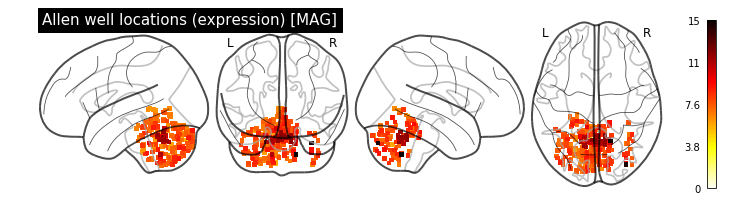

In [32]:
gene_symbol="MAG"
genes2probes = get_probe_ids(gene_symbol,df_probes)
#print("genes2probes:")
#print(genes2probes.head())
gene_expression = get_gene_expression(genes2probes.probe_id,df_donor_data_CB)
#print("gene_expression:")
print("min: {0}, max: {1}".format(np.min(gene_expression.expression),np.max(gene_expression.expression)))
#print(gene_expression.head())
gene_expression_coords = get_MNI_coords(gene_expression,MNI_corr)
#print("gene_expression_coords:")
#print(gene_expression_coords.head())
plot_gene_expression(gene_expression_coords,MNI_brain,gene_symbol=gene_symbol,add_vox_xyz=2,
                     zscore_plotting_data=False,flip_coords_to_left_hemisphere=False)

Gene expression
min: 2.31117223351, max: 5.16890145012
number of wells in data: 368
Mapping of wells to voxels saved to nii.gz file.
Gene expression
min: 6.16357795591, max: 12.2194012173
number of wells in data: 368
Mapping of wells to voxels saved to nii.gz file.


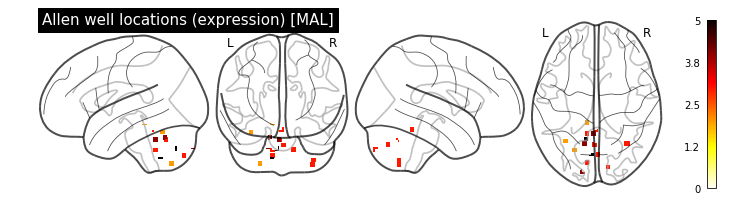

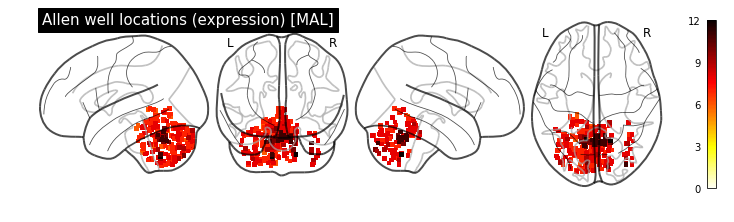

In [317]:
gene_symbol="MAL"
genes2probes = get_probe_ids(gene_symbol,df_probes)
gene_expression = get_gene_expression(genes2probes.loc[0].probe_id,df_donor_data_CB)
print("Gene expression\nmin: {0}, max: {1}".format(np.min(gene_expression.expression),np.max(gene_expression.expression)))
gene_expression_coords = get_MNI_coords(gene_expression,MNI_corr)
plot_gene_expression(gene_expression_coords,MNI_brain,
                     gene_symbol=gene_symbol,add_vox_xyz=2,zscore_plotting_data=False)
gene_expression = get_gene_expression(genes2probes.probe_id,df_donor_data_CB)
print("Gene expression\nmin: {0}, max: {1}".format(np.min(gene_expression.expression),np.max(gene_expression.expression)))
gene_expression_coords = get_MNI_coords(gene_expression,MNI_corr)
plot_gene_expression(gene_expression_coords,MNI_brain,
                     gene_symbol=gene_symbol,add_vox_xyz=2,zscore_plotting_data=False)

Gene expression
min: 4.47782280485, max: 10.3940482217
number of wells in data: 368
Mapping of wells to voxels saved to nii.gz file.


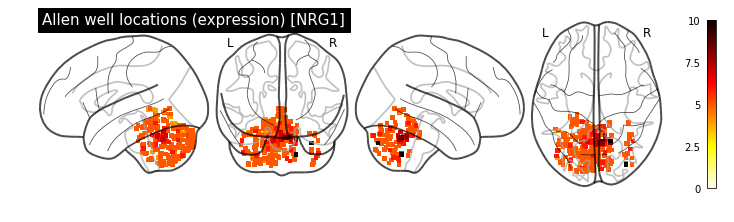

In [319]:
gene_symbol="NRG1"
genes2probes = get_probe_ids(gene_symbol,df_probes)
gene_expression = get_gene_expression(genes2probes.probe_id,df_donor_data_CB)
print("Gene expression\nmin: {0}, max: {1}".format(np.min(gene_expression.expression),np.max(gene_expression.expression)))
gene_expression_coords = get_MNI_coords(gene_expression,MNI_corr)
plot_gene_expression(gene_expression_coords,MNI_brain,gene_symbol=gene_symbol,add_vox_xyz=2,
                     zscore_plotting_data=False,black_bg=False)

Averaging NTRK2 expression across 7 probes
Gene expression
min: 6.88448812939, max: 10.8208828702
number of wells in data: 368
./allen_well_locations_expression_all_NTRK2.nii.gz
Mapping of wells to voxels saved to nii.gz file.


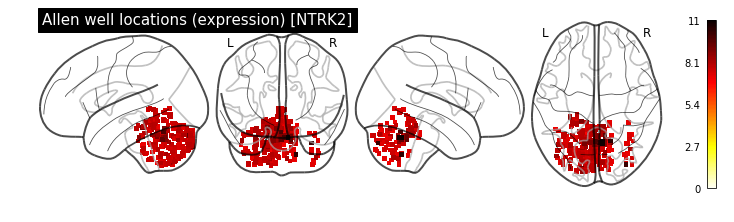

In [93]:
gene_symbol="NTRK2"
genes2probes = get_probe_ids(gene_symbol,df_probes)
gene_expression = get_gene_expression(genes2probes.probe_id,df_donor_data_CB)
print("Gene expression\nmin: {0}, max: {1}".format(np.min(gene_expression.expression),np.max(gene_expression.expression)))
gene_expression_coords = get_MNI_coords(gene_expression,MNI_corr)
plot_gene_expression(gene_expression_coords,MNI_brain,gene_symbol=gene_symbol,
                     add_vox_xyz=2,zscore_plotting_data=False)

In [11]:
df_donor_data_all_goodWells = pd.read_hdf(os.path.join(donor_data_dir,"donors_all_goodWells.hdf"))

Averaging NTRK2 expression across 7 probes
You chose to flip all data to the left hemisphere, there is NO guarantee that there will not
be overlap that is misrepresented in the figure.
number of wells in data: 368
./allen_well_locations_expression_all_NTRK2.nii.gz
./allen_well_locations_expression_all_NTRK2_s5.nii.gz
Mapping of wells to voxels saved to nii.gz file.


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/chris/.local/lib/python2.7/site-packages/nilearn/plotting/glass_brain.py:164: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  black_bg = colors.colorConverter.to_rgba(ax.get_axis_bgcolor()) \
/usr/local/lib/python2.7/dist-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


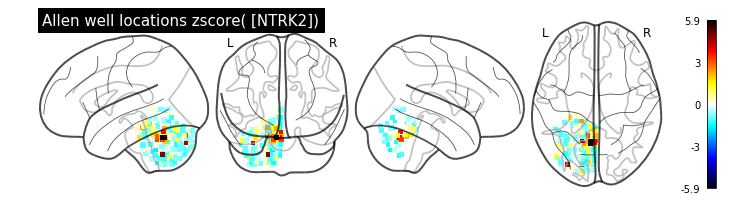

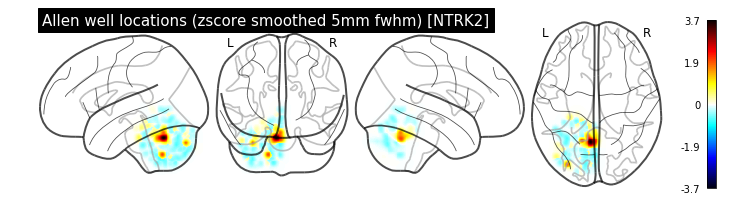

In [12]:
gene_symbol="NTRK2"
genes2probes = get_probe_ids(gene_symbol,df_probes)
gene_expression = get_gene_expression(genes2probes.probe_id,df_donor_data_CB)
#print("Gene expression\nmin: {0}, max: {1}".format(np.min(gene_expression.expression),np.max(gene_expression.expression)))
gene_expression_coords = get_MNI_coords(gene_expression,MNI_corr)
plot_gene_expression(gene_expression_coords,MNI_brain,gene_symbol=gene_symbol,add_vox_xyz=2,
                     zscore_plotting_data=True, black_bg=False,flip_coords_to_left_hemisphere=True,
                     plot_smoothed_data=True)

Averaging NTRK2 expression across 7 probes
You chose to flip all data to the left hemisphere, there is NO guarantee that there will not
be overlap that is misrepresented in the figure.
number of wells in data: 3702
./allen_well_locations_expression_all_NTRK2.nii.gz
./allen_well_locations_expression_all_NTRK2_s5.nii.gz
Mapping of wells to voxels saved to nii.gz file.


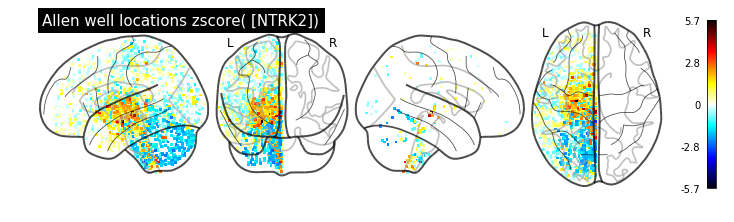

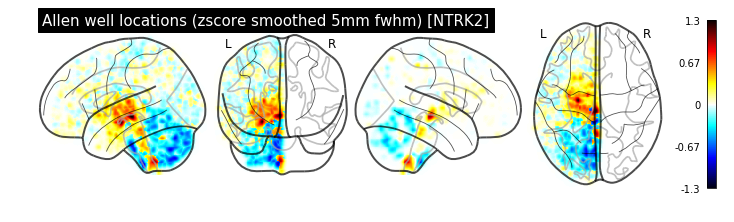

In [44]:
gene_symbol="NTRK2"
genes2probes = get_probe_ids(gene_symbol,df_probes)
gene_expression = get_gene_expression(genes2probes.probe_id,df_donor_data_all_goodWells)
#print("Gene expression\nmin: {0}, max: {1}".format(np.min(gene_expression.expression),np.max(gene_expression.expression)))
gene_expression_coords = get_MNI_coords(gene_expression,MNI_corr)
plot_gene_expression(gene_expression_coords,MNI_brain,gene_symbol=gene_symbol,add_vox_xyz=1,
                     zscore_plotting_data=True, black_bg=False,flip_coords_to_left_hemisphere=True,
                     plot_smoothed_data=True)

4.77104402625


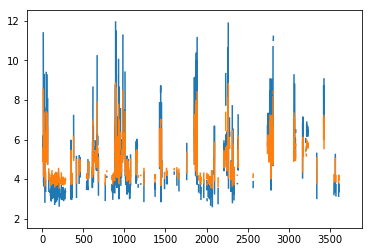

In [358]:
a = gene_expression_coords['expression'].values
a2 = (a-np.nanmean(a))/np.nanstd(a)
print(np.nanmean(a))
plt.plot(a)
plt.plot(a2+np.nanmean(a))

In [286]:
isinstance(genes2probes.loc[0].probe_id,(int,long))

True

  gene_symbol  probe_id
0       SFRS9   1049430
Averaging SFRS9 expression across 1 probes
You chose to flip all data to the left hemisphere, there is NO guarantee that there will not
be overlap that is misrepresented in the figure.
number of wells in data: 893


/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


./allen_well_locations_expression_H0351p2002_SFRS9.nii.gz
./allen_well_locations_expression_H0351p2002_SFRS9_s5.nii.gz
Mapping of wells to voxels saved to nii.gz file.


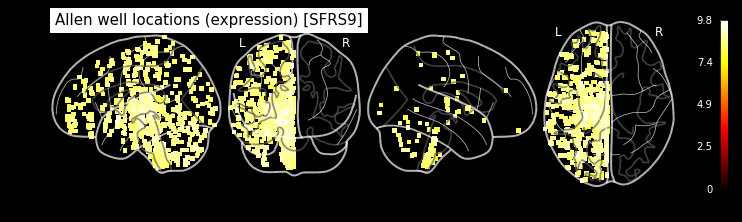

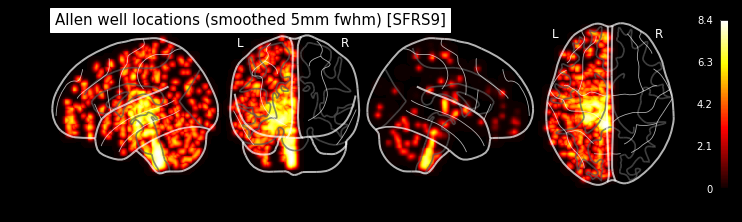

In [99]:
gene_symbol="SLC6A4"
gene_symbol="SLC6A2"
gene_symbol="MAL"
donor_id = "H0351.2002"
gene_symbol = "HTR1A"
gene_symbol = "C2orf3"
gene_symbol = "WBP2"
gene_symbol = "SFRS9"
#gene_symbol="MAL"
#donor_id = None
genes2probes = get_probe_ids(gene_symbol,df_probes)
print(genes2probes)

gene_expression = get_gene_expression(genes2probes.probe_id,df_donor_data_all_goodWells)
gene_expression_coords = get_MNI_coords(gene_expression,MNI_corr)
plot_gene_expression(gene_expression_coords,MNI_brain,gene_symbol=gene_symbol,add_vox_xyz=2,
                     black_bg=True,zscore_plotting_data=False,plot_smoothed_data=True,donor_id = donor_id,
                    flip_coords_to_left_hemisphere = False)